# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [93]:
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Append custom classes to  sys.path

# Import packages
import numpy as np
from pandas.plotting import register_matplotlib_converters
import sys
sys.path.insert(0, "../../../")
register_matplotlib_converters()

# Import modules from dynamic neural network
from libs.dynns.dynamic_neural_networks.utils import *
from libs.dynns.dynamic_neural_networks.transformations.helper_functions import *
from libs.dynns.dynamic_neural_networks.transformations.sorted_real_schur_forms import *
from libs.dynns.dynamic_neural_networks.model.dnn import *
from libs.dynns.dynamic_neural_networks.model.state_space_model import *
from libs.dynns.dynamic_neural_networks.utils.helper_functions import *
from libs.dynns.dynamic_neural_networks.data.diffusion_equation_2d import *

expensive_asserts = False

sys.path.append('../static/py/classes/')
from dynn_models import  DumpedHarmonicOscillator


In [94]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


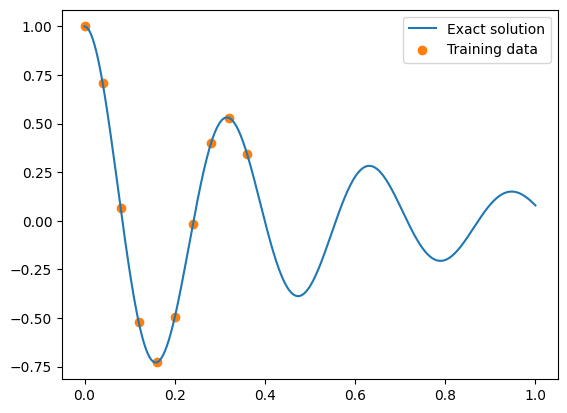

In [95]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Dynamic neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [96]:
d, w0 = 2, 20
dumped_harmonic_oscillator_ssm = DumpedHarmonicOscillator(w0, d)
A, B, C, D = dumped_harmonic_oscillator_ssm.get_ssm()
print(A, B, C, D)
print(A.shape, B.shape, C.shape, D)


ssm = state_space_model(A, B, C, D)

# Timesteps
t_0 = 0.0  # Initial time
t_end = 1 #10.0  # Final time
dt = 0.01  # Determines the input-signal sampling frequency
d_in = 1
timesteps = np.arange(t_0, t_end + dt, dt)  # All time-steps

# Method to interpolate the input function within each time-step
u_interp = "piecewise_linear"  # 'piecewise_constant', 'piecewise_linear', 'sample'

# Set u(t): Forcing term (Heat source/sink) over the grid as a function of time
inputs = dumped_harmonic_oscillator_ssm.get_input(timesteps, d_in,  show_input = True)
print(inputs)



[[   0    1]
 [-400   -4]] [[0]
 [1]] [[1 0]] [[0.]]
(2, 2) (2, 1) (1, 2) [[0.]]
[array([[-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
       [-400.],
      

In [97]:
# Dynamic Neural Network Parameters
n_clusters = 1  # Number of clusters of close eigenvalues
outer_loop = "timesteps"  # 'neurons', 'timesteps'
ode_solver_rel_tol = 1e-10  # relative tolerance for ODE solver
ode_solver_abs_tol = 1e-10  # absolute tolerance for ODE solver
clustering_alg = KMeans(
    n_clusters=n_clusters, random_state=0, n_init="auto"
)  # Clustering algorithm
params = forward_pass_parameters(
    outer_loop=outer_loop,
    ssm_input_interpolation=u_interp,
    solver_routine="solve_ivp",
    ode_solver_params=ode_solver_parameters(
        atol=ode_solver_abs_tol, rtol=ode_solver_rel_tol, ode_solver="DOP853"
    ),
)  # Parameters concerning forward pass of a DyNN

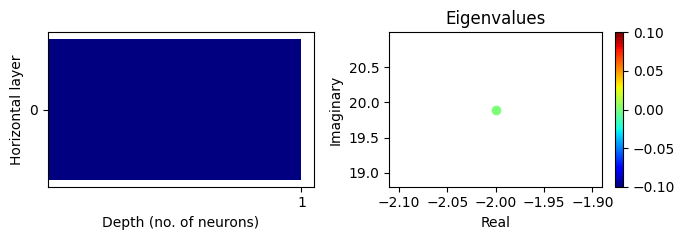

Condition number of the transformation matrix =  1.0


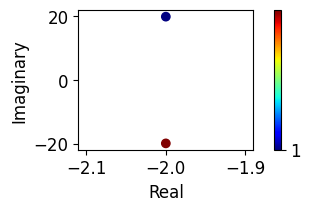

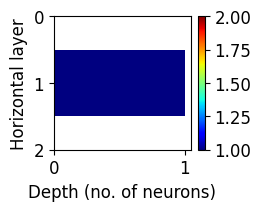

In [98]:
# Initialize the dynamic neural network
dynn = dynamic_neural_network(ssm=ssm)

# Simulate the LTI system using a dynamic neural network
dynn.fit(clustering_alg, verbose=0, show_plots=True)

# Condition number of the transformation matrix
print("Condition number of the transformation matrix = ", dynn.cond_num)

# Plot eigenvalue clusters and DyNN architecture
dynn.plot_architecture(figname="diffusion", fig_size_1=(3, 2), fig_size_2=(2.5, 2), fontsize = 12, color_bar=True, sort_evals=True)

In [99]:
# Perform forward pass and compute output
y_dynn = dynn.predict(inputs, timesteps, params)
y_dynn = y_dynn + 1
print(y_dynn)
plt.figure()
plt.plot(timesteps, y_dynn, label="Exact solution")
plt.scatter(timesteps, y_dynn, color="tab:orange", label="Training data")
plt.legend()
plt.show()
# Plot: Avg number of function evaluations in each horizontal layer.
#dynn.plot_NFE(figname="diffusion", fig_size=(2.5, 2), fontsize=12, x_label='Neuron', y_label="NFE", color_bar=True, sort_evals=True)

[[ 1.        ]
 [ 0.98032954]
 [ 0.92311906]
 [ 0.83207631]
 [ 0.71208582]
 [ 0.56897189]
 [ 0.40923409]
 [ 0.23976682]
 [ 0.06757436]
 [-0.10050715]
 [-0.25807026]
 [-0.39936984]
 [-0.5195216 ]
 [-0.61465922]
 [-0.68204553]
 [-0.72013522]
 [-0.72858848]
 [-0.70823703]
 [-0.66100563]
 [-0.58979408]
 [-0.4983256 ]
 [-0.39096907]
 [-0.27254296]
 [-0.14810942]
 [-0.02276687]
 [ 0.09855067]
 [ 0.21125991]
 [ 0.31129371]
 [ 0.39523976]
 [ 0.46044826]
 [ 0.50510556]
 [ 0.52827228]
 [ 0.52988572]
 [ 0.51072794]
 [ 0.47236208]
 [ 0.41704064]
 [ 0.34759042]
 [ 0.26727954]
 [ 0.1796724 ]
 [ 0.08847878]
 [-0.00259684]
 [-0.08999985]
 [-0.17045854]
 [-0.24110088]
 [-0.29955106]
 [-0.34400291]
 [-0.37326812]
 [-0.38679851]
 [-0.38468226]
 [-0.36761559]
 [-0.33685168]
 [-0.29412987]
 [-0.2415886 ]
 [-0.18166621]
 [-0.11699389]
 [-0.05028528]
 [ 0.0157728 ]
 [ 0.0786243 ]
 [ 0.13593872]
 [ 0.18569332]
 [ 0.22624011]
 [ 0.25635556]
 [ 0.27527179]
 [ 0.28268867]
 [ 0.27876725]
 [ 0.26410535]
 [ 0.23969

In [100]:
# Simulate the LTI system using python routine lsim
y_lsim = numerical_simulation_lsim(timesteps, inputs[0], ssm, interp=True)

# Simulate the LTI system using python routine solve_ivp
y_solve_ivp, nfe_solver = numerical_simulation_ivp_solve(
    ssm,
    inputs,
    timesteps,
    u_interp,
    outer_loop,
    rtol=ode_solver_rel_tol,
    atol=ode_solver_abs_tol,
)
print(y_lsim)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


Compare the simulation results

In [101]:
# Compute relative and absolute errors
abs_err_lsim = abs(y_dynn - y_lsim)
print("Max absolute error (DyNN and solver:lsim) :", np.amax(abs_err_lsim))

abs_err_solve_ivp = abs(y_dynn - y_solve_ivp)
print("Max absolute error (DyNN and solver:solve_ivp) :", np.amax(abs_err_solve_ivp))

abs_err_between_solvers = abs(y_lsim - y_solve_ivp)
print("Max absolute error between solvers :", np.amax(abs_err_between_solvers))

Max absolute error (DyNN and solver:lsim) : 1.0
Max absolute error (DyNN and solver:solve_ivp) : 1.000000000000022
Max absolute error between solvers : 1.7285884848835609


In [102]:
# Comparison of PDE solutions: (a) using the constructed dynamic neural
# network (DyNN), and (b) numerical solver along with the absolute errors.
compare_pde_solutions(
    timesteps, l_x, l_y, nx, ny, y_dynn, y_lsim, fig_size=(4, 2.5), save_fig=True, figname='diff_sol_err.pdf', fontsize = 12
)

NameError: name 'l_x' is not defined